In [1]:
import utils.data_import as data_import
import utils.ml_utils as ml_utils

import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd

/anaconda3/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
import settings

if settings.ORIG_DATA == 0:
    train_file = 'training.txt'
    train, valid = data_import.normalize_and_split(org_data_path, train_file, test_size=settings.test_size)
elif settings.ORIG_DATA == 1:
    train_file = settings.imdb_file
    train, valid = data_import.import_imbd(train_file, to=10000, test_size=settings.test_size)
elif settings.ORIG_DATA == 2:
    df = data_import.import_wikitext(window_size=settings.window_size, lines=settings.lines)
    train, valid = data_import.create_splits(df, test_size=settings.test_size)

text length: 213886


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')
    import matplotlib.pyplot as plt
    %matplotlib inline

No cuda.


In [4]:
valid.head()

,tag,statement,tag_id
2648,ship,"following day , aware that Australia was now a...",875
2456,as,convoy escort and maritime reconnaissance duti...,336
4557,to,"<unk> . The road , now called Main Street , pa...",6
4884,current,@-@ 25 and ran north of <unk> to the vicinity ...,1188
92,highly,"lobster red "" on cooking . Mating occurs in th...",64


In [5]:
data_import.create_split_files('.', train, valid)

Writing files to ./data
Train and validation files written to disk.
Sizes: (4000, 3) (1000, 3)


In [6]:
data_path = './data'

In [7]:
TEXT = data.Field(sequential=True, lower=True)
LABEL = data.Field(sequential=False, use_vocab=False)
SENTIMENT = data.Field(sequential=False, use_vocab=False)

In [8]:
datafields = [('tag', None),
              ('statement', TEXT),
              ('tag_id', LABEL)]

train, test = data.TabularDataset.splits(
    path=data_path,
    train='train.csv', validation='valid.csv',
    format='csv',
    skip_header=True,
    fields=datafields)

In [9]:
train_file_imdb = settings.imdb_file
train_imdb, valid_imdb = data_import.import_imbd(train_file_imdb, to=10000, test_size=settings.test_size)
data_import.create_split_files('./imdb', train_imdb, valid_imdb)

datafields = [('tag', None),
              ('statement', TEXT),
              ('tag_id', SENTIMENT)]

train_imdb, test_imdb = data.TabularDataset.splits(
    path='./imdb/data',
    train='train.csv', validation='valid.csv',
    format='csv',
    skip_header=True,
    fields=datafields)

Writing files to ./imdb/data
Train and validation files written to disk.
Sizes: (8000, 3) (2000, 3)


In [10]:
TEXT.build_vocab(train, test, train_imdb, test_imdb, vectors='glove.6B.'+str(settings.emb_dim)+'d')
#TEXT.build_vocab(train, test, train_imdb, test_imdb)
LABEL.build_vocab(train, test)
SENTIMENT.build_vocab(train_imdb, test_imdb)

In [11]:
n_vocab = len(dict(TEXT.vocab.freqs).keys())
print('Vocab size:', n_vocab)
n_classes = len(dict(LABEL.vocab.freqs).keys())
print('Number of classes:', n_classes)
n_sent = len(dict(SENTIMENT.vocab.freqs).keys())
print('Number of sentiments:', n_sent)

Vocab size: 144445
Number of classes: 1322
Number of sentiments: 2


In [12]:
print('len(trn):', len(train))
print('len(test):', len(test))
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
#print(vars(train[0]))
#print(LABEL.vocab.stoi)
#print(SENTIMENT.vocab.stoi)

len(trn): 4000
len(test): 1000
[('the', 146676), ('and', 70395), ('a', 68633), ('of', 67241), ('to', 60166), ('in', 44494), ('is', 43378), ('i', 28440), ('this', 28109), ('that', 27029), ('it', 26986), ('was', 23067), ('as', 20572), ('/><br', 20564), (',', 18905), ('with', 18705), ('for', 18161), ('<unk>', 16568), ('on', 16407), ('but', 15945)]
['<unk>', '<pad>', 'the', 'and', 'a', 'of', 'to', 'in', 'is', 'i']


In [13]:
print(TEXT.vocab.vectors.shape)
vocab_size = len(TEXT.vocab)
TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

torch.Size([144446, 50])


tensor([ 0.4180,  0.2497, -0.4124,  0.1217,  0.3453, -0.0445, -0.4969, -0.1786,
        -0.0007, -0.6566,  0.2784, -0.1477, -0.5568,  0.1466, -0.0095,  0.0117,
         0.1020, -0.1279, -0.8443, -0.1218, -0.0168, -0.3328, -0.1552, -0.2313,
        -0.1918, -1.8823, -0.7675,  0.0991, -0.4212, -0.1953,  4.0071, -0.1859,
        -0.5229, -0.3168,  0.0006,  0.0074,  0.1778, -0.1590,  0.0120, -0.0542,
        -0.2987, -0.1575, -0.3476, -0.0456, -0.4425,  0.1878,  0.0028, -0.1841,
        -0.1151, -0.7858])

In [14]:
#trn, vld = train.split(0.7)
trn = train
vld = test
print('len(trn):', len(trn))
print('len(vld):', len(vld))
#print('len(test):', len(test))

len(trn): 4000
len(vld): 1000


In [15]:
train_iter, val_iter = data.BucketIterator.splits(
    datasets=(trn, vld),
    batch_sizes=(settings.batch_size, settings.batch_size),
    sort_key=lambda x: len(x.statement),
    sort_within_batch=False,
    repeat=False
)

In [16]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_fields):
        self.dl, self.x_field, self.y_fields = dl, x_field, y_fields
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_fields)
            #y = torch.cat([getattr(batch, feat).unsqueeze(1) 
            #               for feat in self.y_fields], dim=1).float()
            if cuda:
                X = X.cuda()
            yield (X, y)

In [17]:
train_dl = BatchGenerator(train_iter, 'statement', 'tag_id')
valid_dl = BatchGenerator(val_iter, 'statement', 'tag_id')

In [18]:
# Requires padding to be set to 100
class SimpleForward(nn.Module):
    def __init__(self, pretrained_vec, emb_dim=50):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = False
        
        self.linear_layer = nn.Linear(emb_dim*100, 128)
        self.linear_out = nn.Linear(128, n_classes)
        
    def forward(self, seq):
        
        seq = seq.permute(1, 0)
        emb = self.embedding(seq)
        
        long_layer = emb.view(-1, emb_dim*100)
        
        out = F.relu(self.linear_layer(long_layer))
        out = self.linear_out(out)
        
        return F.log_softmax(out, dim=-1)
        

In [19]:
class CNN(nn.Module):
    def __init__(self, pretrained_vec, emb_dim, n_channels_per_filter, filter_sizes):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = False
        
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[0], emb_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[1], emb_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_channels_per_filter,
                                kernel_size=(filter_sizes[2], emb_dim))
        
        self.fc = nn.Linear(len(filter_sizes)*n_channels_per_filter, n_classes)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, seq):
        
        seq = seq.permute(1, 0)
        emb = self.embedding(seq)
        
        #print(seq.shape)
        #print(emb.shape)
        
        emb = emb.unsqueeze(1) # introduce 'channel 1'
        
        #print('emb:', emb.shape)
        
        out0 = F.relu(self.conv_0(emb).squeeze(3))
        out1 = F.relu(self.conv_1(emb).squeeze(3))
        out2 = F.relu(self.conv_2(emb).squeeze(3))
        
        #print('out0:', out0.shape)
        
        pooled_0 = F.max_pool1d(out0, out0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(out1, out1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(out2, out2.shape[2]).squeeze(2)
        
        #print('pooled0:', pooled_0.shape)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        
        #print('cat:', cat.shape)
        
        out = self.fc(cat)
        
        return F.log_softmax(out, dim=-1)

In [20]:
class simpleRNN(nn.Module):
    def __init__(self, pretrained_vec, emb_dim, hidden_dim, change_emb=True):
        super().__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.embedding.weight.data.copy_(pretrained_vec)
        self.embedding.weight.requires_grad = change_emb
        
        self.rnn = nn.RNN(emb_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, seq):
        # seq dims: [seq len, batch size]
        emb = self.embedding(seq)
        # emb dims: [seq len, batch size, emb dim]
        out, hid = self.rnn(emb)
        # out dims: [seq len, batch size, hidden_dim]
        # hid dims: [1, batch size, hidden_dim]
        # hid.squeeze(0) -> [batch size, hidden_dim]
        out = self.fc(hid.squeeze(0))
        # out dims: [batch size, n_classes]
        sm = F.log_softmax(out, dim=-1)
        # sm dims: [batch size, n_classes]
        
        return sm

In [21]:
class simpleLSTM(nn.Module):
    def __init__(self, emb_dim, hidden_dim, n_layers=1, pretrained_vec=torch.zeros(0),
                 change_emb=True, dropout=0):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        if len(pretrained_vec) > 0:
            print('Loaded pretrained vectors.')
            self.embedding.weight.data.copy_(pretrained_vec)
        else:
            print('Not loaded pretrained vectors.')
        
        self.embedding.weight.requires_grad = change_emb
        
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, dropout=dropout)
        
        self.fc = nn.Linear(2*hidden_dim, n_classes)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seq):
        #pdb.set_trace()
        # seq dims: [seq len, batch size]
        
        emb = self.embedding(seq)
        # emb dims: [seq len, batch size, emb dim]
        
        out, (hid, cel) = self.lstm(emb)
        
        # out dims: [seq len, batch size, hidden_dim]
        # hid dims: [2*n_layers, batch size, hidden_dim]
        # cel dims: [2*n_layers, batch size, hidden_dim]
        # out[-1,:,:hd] -> [batch size, hidden_dim]  (last time step hidden vector)
        # out[0,:,hd:] <- [batch size, hidden_dim]  (first time step hidden vector)
        conc = torch.cat((out[-1,:,:self.hidden_dim], out[0,:,self.hidden_dim:]), dim=1)
        
        conc = self.dropout(conc)
        
        out = self.fc(conc)
        # out dims: [batch size, n_classes]
        sm = F.log_softmax(out, dim=-1)
        # sm dims: [batch size, n_classes]
        
        return sm

In [22]:
#model = CNN(TEXT.vocab.vectors,
#            emb_dim=emb_dim,
#            n_channels_per_filter=100,
#            filter_sizes=[3, 4, 5]
#           )

In [23]:
model = simpleLSTM(emb_dim=settings.emb_dim,
                   hidden_dim=settings.hidden_dim,
                   n_layers=settings.num_linear,
                   pretrained_vec=TEXT.vocab.vectors,
                   change_emb=True,
                   dropout=settings.dropout
                  )
if cuda:
    model = model.cuda()

Loaded pretrained vectors.


In [24]:
#x, y = next(iter(train_dl))
#pred = model(x)
#print(x.shape)
#print(y.shape)
#print(pred.shape)

In [25]:
len(vars(trn[0])['statement'])

70

In [26]:
loss_func = nn.NLLLoss()

In [27]:
print(model)

simpleLSTM(
  (embedding): Embedding(144446, 50)
  (lstm): LSTM(50, 100, num_layers=3, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1322, bias=True)
  (dropout): Dropout(p=0.5)
)


In [28]:
import tqdm

def run_epochs(model, train_dl, valid_dl):
    
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.NLLLoss()

    epochs = settings.epochs

    missclass = []
    losses = []
 
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model.train() # turn on training mode

        num_vals = 0
        num_correct = 0

        #pdb.set_trace()

        #for x, y in train_dl: 
        for x, y in tqdm.tqdm(train_dl): 
            opt.zero_grad()

            preds = model(x)
            loss = loss_func(preds, y.long())

            loss.backward()
            opt.step()


            running_loss += loss.item() * x.size(0)

            _, y_pred = torch.max(preds, dim=1)
            num_correct += torch.sum(y == y_pred).item()
            num_vals += len(y.float())

        #pdb.set_trace()

        missclass_tr = 1 - num_correct / num_vals

        epoch_loss = running_loss / len(trn)

        num_vals = 0
        num_correct = 0

        # calculate the validation loss for this epoch
        val_loss = 0.0
        model.eval() # turn on evaluation mode
        for x, y in tqdm.tqdm(valid_dl):
            preds = model(x)
            loss = loss_func(preds, y.long())

            val_loss += loss.item() * x.size(0)

            _, y_pred = torch.max(preds, dim=1)
            num_correct += torch.sum(y == y_pred).item()
            num_vals += len(y.float())

        #pdb.set_trace()

        missclass_te = 1 - num_correct / num_vals
        val_loss /= len(vld)

        missclass.append((missclass_tr, missclass_te))
        losses.append((epoch_loss, val_loss))

        print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Miss: [{:.2%}, {:.2%}]'\
              .format(epoch, epochs, epoch_loss, val_loss, missclass_tr, missclass_te))
        sys.stdout.flush()
        
    return model, opt, losses, missclass

In [29]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl)

100%|██████████| 63/63 [00:04<00:00, 12.68it/s]

Epoch: 1/5, Loss: [27.2423, 26.3458], Miss: [95.53%, 94.20%]



100%|██████████| 63/63 [00:06<00:00,  9.79it/s]

Epoch: 2/5, Loss: [25.9606, 26.7518], Miss: [95.43%, 94.20%]



100%|██████████| 63/63 [00:04<00:00, 12.96it/s]

Epoch: 3/5, Loss: [25.8616, 27.0011], Miss: [95.50%, 94.20%]



100%|██████████| 63/63 [00:05<00:00, 12.09it/s]

Epoch: 4/5, Loss: [25.7799, 27.2375], Miss: [95.03%, 94.20%]



100%|██████████| 63/63 [00:05<00:00, 12.52it/s]

Epoch: 5/5, Loss: [25.6222, 27.4742], Miss: [95.50%, 94.20%]


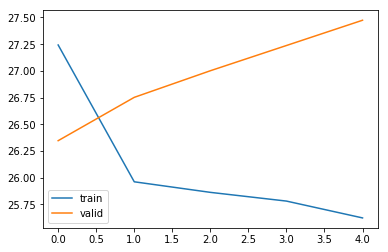

In [30]:
if not cuda:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

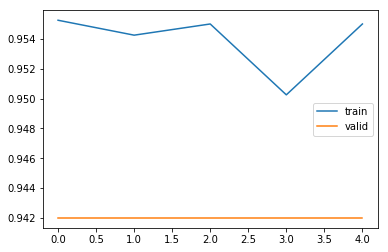

In [31]:
if not cuda:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])

In [32]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [33]:
# Replace fc with sentiment layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_sent)
if cuda:
    model = model.cuda()

In [34]:
print(model)

simpleLSTM(
  (embedding): Embedding(144446, 50)
  (lstm): LSTM(50, 100, num_layers=3, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0.5)
)


In [35]:
train_imdb_iter, val_imdb_iter = data.BucketIterator.splits(
    datasets=(train_imdb, test_imdb),
    batch_sizes=(settings.batch_size, settings.batch_size),
    sort_key=lambda x: len(x.statement),
    sort_within_batch=False,
    repeat=False
)

In [36]:
train_imdb_dl = BatchGenerator(train_imdb_iter, 'statement', 'tag_id')
valid_imdb_dl = BatchGenerator(val_imdb_iter, 'statement', 'tag_id')

In [ ]:
model, opt, losses, missclass = run_epochs(model, train_imdb_dl, valid_imdb_dl)

 87%|████████▋ | 435/500 [04:35<00:41,  1.58it/s]